In [1]:
!pip install --upgrade yfinance==0.2.54
!pip install arch
!pip install scikit-learn
!pip install --upgrade yfinance==0.2.54
!pip install arch
!pip install scikit-learn
!pip install pandas_datareader
!pip install PyPortfolioOpt
!pip install pandas_datareader
!pip install PyPortfolioOpt

Forecast for Mkt-RF: Mean = 0.01016400289991215, Variance = 0.0016505269945385483
Forecast for SMB: Mean = 0.0006864029404214378, Variance = 0.0011731800077627638


[*********************100%***********************]  8 of 8 completed
[******************    38%                       ]  3 of 8 completed

Forecast for HML: Mean = 0.0023962797673686698, Variance = 0.0008347280333907814


[*********************100%***********************]  8 of 8 completed


Annualized Expected Returns:
 {'AAPL': np.float64(0.24640194317189867), 'MSFT': np.float64(0.19477501808209813), 'GOOG': np.float64(0.1665268876487669), 'BRK-B': np.float64(0.11773450707307034), 'JPM': np.float64(0.18655503067626614), 'JNJ': np.float64(0.09378916306584825), 'V': np.float64(0.18643833934216453), 'PG': np.float64(0.08795461652673442)}
Annualized Forecast Error Variance:
 {'AAPL': np.float64(0.2729558687228993), 'MSFT': np.float64(0.23152203664251803), 'GOOG': np.float64(0.25267996106538854), 'BRK-B': np.float64(0.17408335162426183), 'JPM': np.float64(0.23254868035521928), 'JNJ': np.float64(0.16215287997199845), 'V': np.float64(0.2076461655810449), 'PG': np.float64(0.16651835378995347)}

 *******Horizon: 12 months*******
S_sample:
 Ticker      AAPL     BRK-B      GOOG       JNJ       JPM      MSFT        PG  \
Ticker                                                                         
AAPL    0.005959  0.001252  0.002384  0.000923  0.001723  0.002462  0.000905   
BRK-

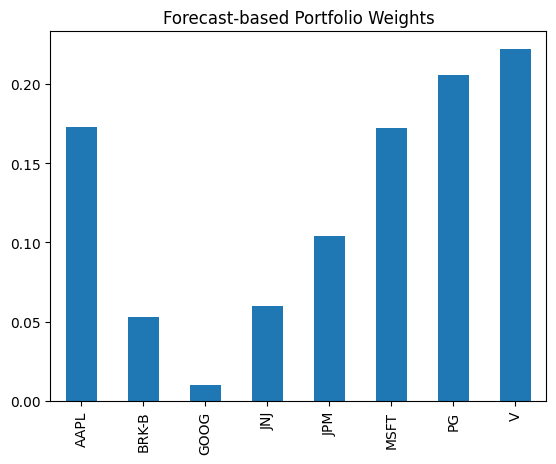

[*********************100%***********************]  1 of 1 completed


Market-implied prior returns:
 Ticker
AAPL     0.331238
BRK-B    0.114724
GOOG     0.246653
JNJ      0.081763
JPM      0.204036
MSFT     0.243868
PG       0.067188
V        0.176137
dtype: float64
Black-Litterman Portfolio Performance: (np.float64(0.23297275375324666), np.float64(0.21209552803139367), np.float64(1.0984331254677036))


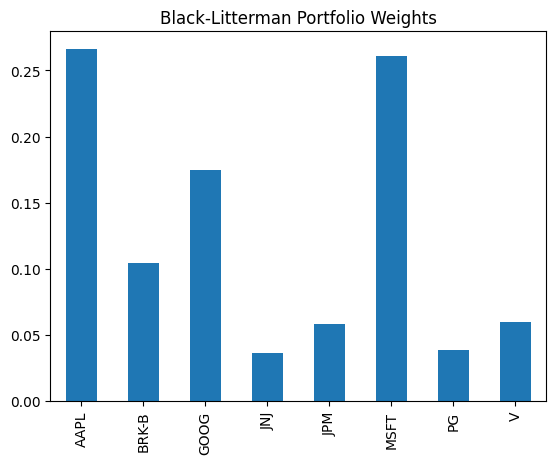

Market Prior Portfolio Performance: (np.float64(0.2356770329442749), np.float64(0.21270858039654425), np.float64(1.107980846399856))


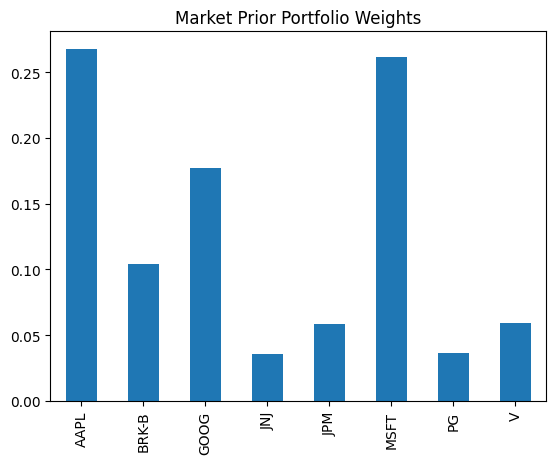

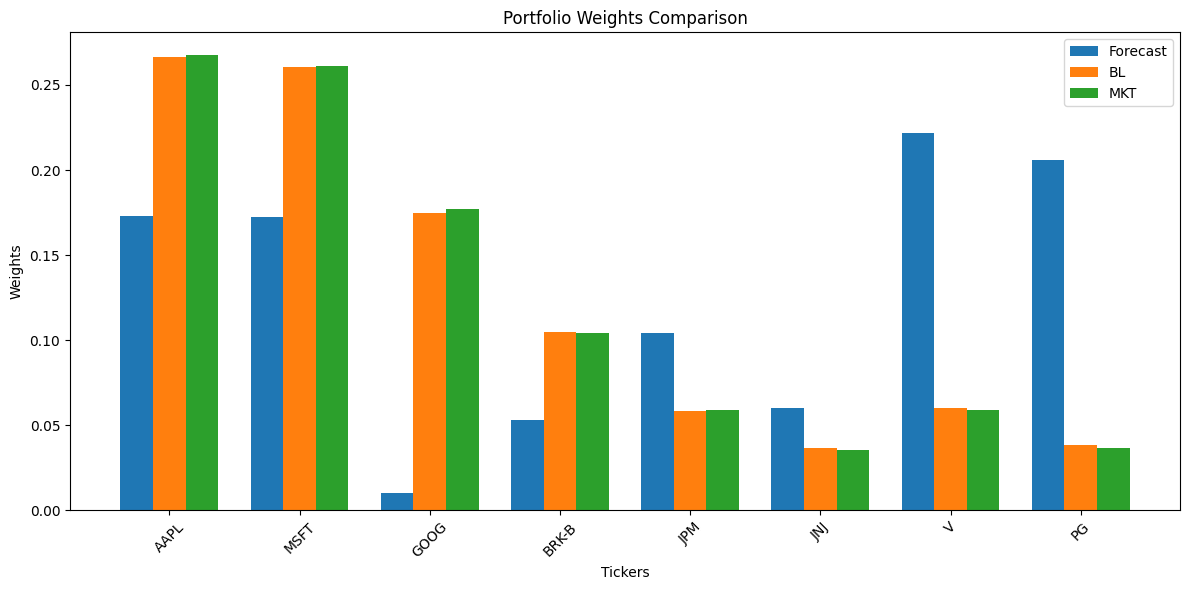

Out-of-sample return for forecast-based portfolio: 0.20263206772913622
Out-of-sample Sharpe ratio for forecast-based portfolio: 1.939683
Out-of-sample return for Black-Litterman portfolio: 0.25821642171033665
Out-of-sample Sharpe ratio for Black-Litterman portfolio: 2.690949
Out-of-sample return for Market Prior portfolio: 0.259322497279999
Out-of-sample Sharpe ratio for Market Prior portfolio: 2.698857

 *******Horizon: 3 months*******
S_sample:
 Ticker      AAPL     BRK-B      GOOG       JNJ       JPM      MSFT        PG  \
Ticker                                                                         
AAPL    0.005959  0.001252  0.002384  0.000923  0.001723  0.002462  0.000905   
BRK-B   0.001252  0.002215  0.001130  0.001090  0.002047  0.001006  0.000713   
GOOG    0.002384  0.001130  0.004911  0.000686  0.002116  0.002475  0.000600   
JNJ     0.000923  0.001090  0.000686  0.001938  0.001128  0.000909  0.000897   
JPM     0.001723  0.002047  0.002116  0.001128  0.005526  0.002058  

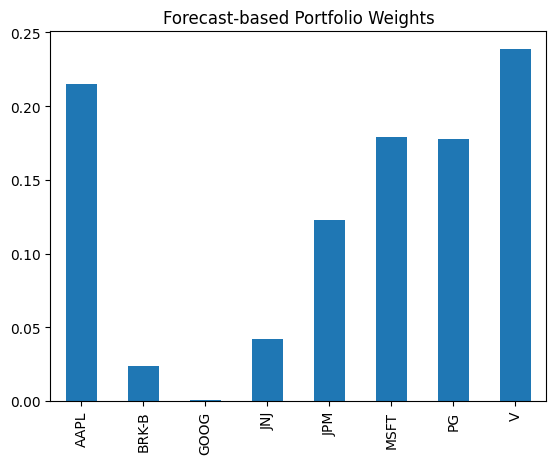

[*********************100%***********************]  1 of 1 completed


Market-implied prior returns:
 Ticker
AAPL     0.054966
BRK-B    0.022083
GOOG     0.044561
JNJ      0.016079
JPM      0.036438
MSFT     0.043279
PG       0.013258
V        0.031758
dtype: float64
Black-Litterman Portfolio Performance: (np.float64(0.04249703553588148), np.float64(0.08837089159952863), np.float64(0.48089404516213075))


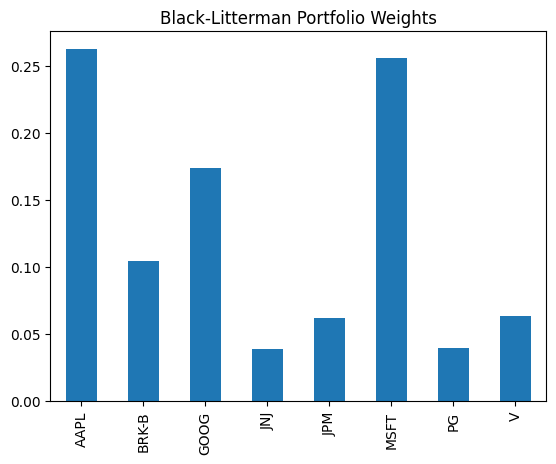

Market Prior Portfolio Performance: (np.float64(0.04126999779631227), np.float64(0.08901098377309977), np.float64(0.46365061981018774))


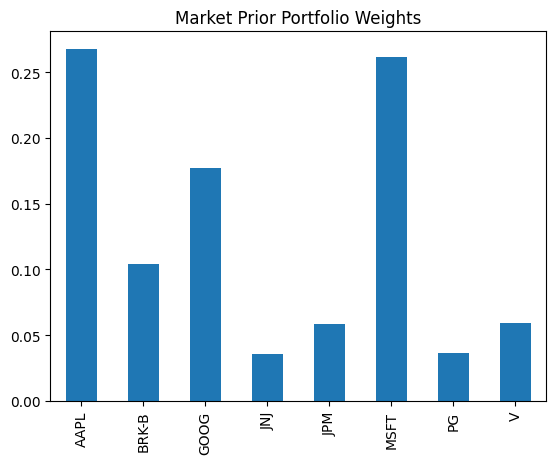

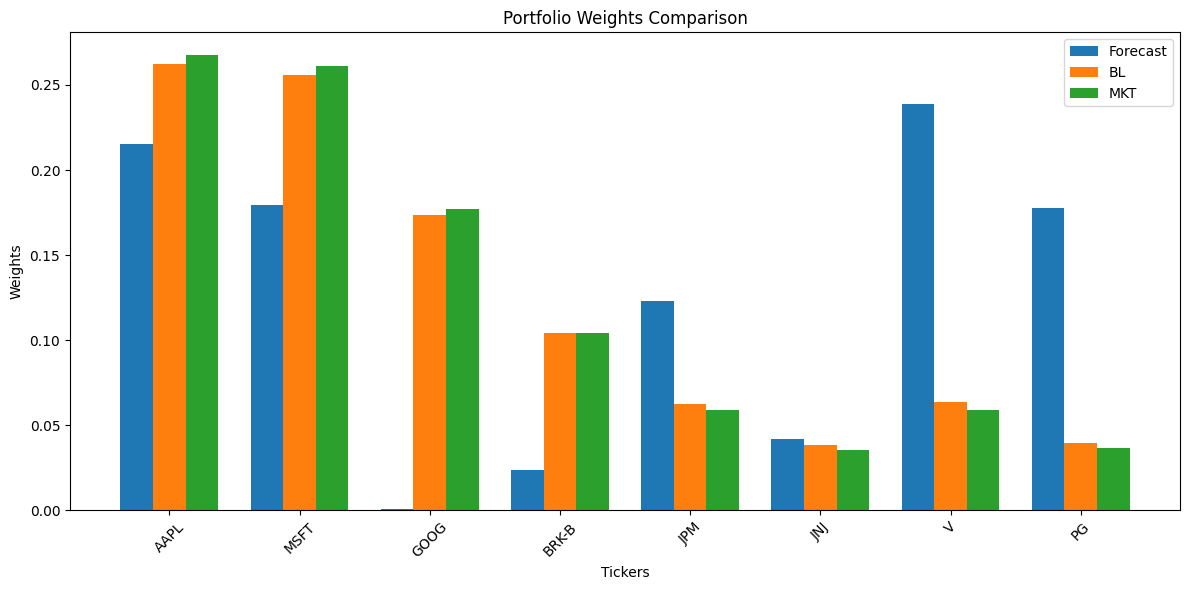

Out-of-sample return for forecast-based portfolio: 0.22057536537254085
Out-of-sample Sharpe ratio for forecast-based portfolio: 2.087480
Out-of-sample return for Black-Litterman portfolio: 0.2580890623055889
Out-of-sample Sharpe ratio for Black-Litterman portfolio: 2.714140
Out-of-sample return for Market Prior portfolio: 0.259322497279999
Out-of-sample Sharpe ratio for Market Prior portfolio: 2.698857


In [2]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from arch import arch_model
from pypfopt import EfficientFrontier, risk_models, black_litterman
from pypfopt.black_litterman import BlackLittermanModel
import cvxpy as cp

# ----------------------------
# DATA LOADING FUNCTIONS
# ----------------------------

def load_fama_french_data(filepath: str) -> pd.DataFrame:
    """
    Load and process Fama-French factor data from a CSV file.
    """
    ff = pd.read_csv(filepath, skiprows=4, header=0,
                     names=['Date', 'Mkt-RF', 'SMB', 'HML', 'RF'])
    ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m')
    ff.set_index('Date', inplace=True)
    # Convert percentages to decimals
    ff = ff.astype(float) / 100
    return ff

def download_stock_prices(tickers: list, start_date: str, end_date: str, interval: str = '1mo') -> pd.DataFrame:
    """
    Download stock prices using yfinance.
    """
    prices = yf.download(tickers, start=start_date, end=end_date,
                          interval=interval, auto_adjust=True)['Close']
    return prices

def download_index_data(index_symbol: str, start_date: str, end_date: str, interval: str = '1mo') -> pd.Series:
    """
    Download index data (e.g. S&P500) using yfinance.
    """
    index_data = yf.download(index_symbol, start=start_date, end=end_date,
                             interval=interval, auto_adjust=True)['Close']
    return index_data

# ----------------------------
# GARCH FORECASTING FUNCTIONS
# ----------------------------

def garch_aic_sel(returns: pd.Series):
    """
    Select the best GARCH model parameters based on AIC.
    """
    mean_models = ['Constant', 'AR']
    vol_models = ['GARCH', 'EGARCH']
    dists = ['normal', 't']
    results = []

    for mean in mean_models:
        for vol in vol_models:
            for dist in dists:
                lags = 1 if mean == 'AR' else 0
                model = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res = model.fit(disp='off')
                results.append({'mean': mean, 'vol': vol, 'dist': dist, 'aic': res.aic})

    results_df = pd.DataFrame(results)
    best_model = results_df.loc[results_df['aic'].idxmin()]
    return best_model['mean'], best_model['vol'], best_model['dist']

def forecast_factor(series: pd.Series, scale: float = 100) -> dict:
    """
    Forecast a factor’s next period mean and variance using an optimal GARCH(1,1).

    Parameters:
      series: Time series of factor returns (simple returns).
      scale: Scaling factor for numerical stability.

    Returns:
      Dictionary with keys 'next_step_mean' and 'next_step_variance'.
    """
    # Convert to log returns
    series = np.log(1 + series.dropna())
    scaled_series = scale * series
    mean, vol, dist = garch_aic_sel(scaled_series)
    am = arch_model(scaled_series, mean=mean, vol=vol, p=1, q=1, dist=dist)
    res = am.fit(disp='off')
    forecast = res.forecast(horizon=1, reindex=False)

    # Scale back forecasted values
    next_mean_scaled = forecast.mean.iloc[-1, 0] / scale
    next_variance_scaled = forecast.variance.iloc[-1, 0] / (scale ** 2)

    # Convert log-return forecast to simple return forecast (log-normal transformation)
    next_step_mean = np.exp(next_mean_scaled + next_variance_scaled / 2) - 1
    next_step_variance = (np.exp(next_variance_scaled) - 1) * np.exp(2 * next_mean_scaled + next_variance_scaled)

    return {'next_step_mean': next_step_mean, 'next_step_variance': next_step_variance}

# ----------------------------
# REGRESSION & FORECAST FUNCTIONS
# ----------------------------

def run_factor_regressions(returns: pd.DataFrame, ff: pd.DataFrame) -> tuple:
    """
    Run OLS regressions for each ticker against the Fama-French factors.

    Returns:
      regression_results: dict of regression models.
      coefficients: dict of estimated coefficients for each ticker.
    """
    tickers = returns.columns.tolist()
    regression_results = {}
    coefficients = {}

    for ticker in tickers:
        df = pd.DataFrame({'r': returns[ticker]})
        df = df.join(ff[['Mkt-RF', 'SMB', 'HML', 'RF']])
        df['excess'] = df['r'] - df['RF']  # compute excess returns
        X = sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']])
        y = df['excess']
        model = sm.OLS(y, X).fit()
        regression_results[ticker] = model
        coefficients[ticker] = {
            'alpha': model.params['const'],
            'Mkt-RF': model.params['Mkt-RF'],
            'SMB': model.params['SMB'],
            'HML': model.params['HML']
        }
    return regression_results, coefficients

def forecast_expected_returns(coefficients: dict, factor_forecasts: dict, factors: list = ['Mkt-RF', 'SMB', 'HML']) -> dict:
    """
    Forecast expected returns for each ticker using regression coefficients and factor forecasts.
    """
    forecast_r = {}
    for ticker, coeff in coefficients.items():
        r_forecast = coeff['alpha']
        for factor in factors:
            r_forecast += coeff[factor] * factor_forecasts[factor]['next_step_mean']
        forecast_r[ticker] = r_forecast
    return forecast_r

def forecast_error_variance(regression_results: dict, coefficients: dict, factor_forecasts: dict,
                            factors: list = ['Mkt-RF', 'SMB', 'HML']) -> dict:
    """
    Calculate total forecast error variance for each ticker.
    """
    forecast_errors = {}
    for ticker, model in regression_results.items():
        beta_squared_sum = sum(coefficients[ticker][factor]**2 * factor_forecasts[factor]['next_step_variance']
                               for factor in factors)
        sigma2_reg = model.mse_resid  # regression residual variance
        forecast_errors[ticker] = beta_squared_sum + sigma2_reg
    return forecast_errors

def mvar_lognormal_transform(mu: pd.Series, sigma: pd.DataFrame, horizon: int = 1) -> tuple:
    """
    Transform single-period log-return mean and covariance (mu, sigma)
    to multi-period simple return mean and covariance.
    """
    mu = mu * horizon
    sigma = sigma * horizon
    mu_ln = np.exp(mu + np.diag(sigma) / 2)
    outerprod = np.outer(mu_ln, mu_ln)
    sigma_ln = outerprod * (np.exp(sigma) - 1)
    return mu_ln - 1, sigma_ln

# ----------------------------
# PYPORTFOLIOOPT WRAPPER FUNCTIONS
# ----------------------------

def optimize_portfolio(mu: np.ndarray, S: np.ndarray, method: str = 'max_sharpe'):
    """
    Optimize a portfolio given expected returns (mu) and covariance matrix (S).

    Currently supports the 'max_sharpe' method.

    Returns:
      weights: dict of asset weights.
      performance: tuple of portfolio performance metrics.
      ef: the EfficientFrontier instance.
    """
    ef = EfficientFrontier(mu, S)
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    else:
        raise ValueError("Unsupported optimization method.")
    performance = ef.portfolio_performance(verbose=False)
    return weights, performance, ef

def optimize_black_litterman(S: np.ndarray, prior: np.ndarray, views: dict, omega: np.ndarray,
                             method: str = 'max_sharpe', tau: float = 0.05):
    """
    Optimize a portfolio using the Black-Litterman approach.

    Returns:
      weights: dict of asset weights.
      performance: tuple of portfolio performance metrics.
      mu_bl: Black-Litterman adjusted expected returns.
      ef: the EfficientFrontier instance.
    """
    bl = BlackLittermanModel(S, pi=prior, absolute_views=views, omega=omega, tau=tau)
    mu_bl = bl.bl_returns()
    ef = EfficientFrontier(mu_bl, S)
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    else:
        raise ValueError("Unsupported optimization method.")
    performance = ef.portfolio_performance(verbose=False)
    return weights, performance, mu_bl, ef

def optimize_market_portfolio(prior: np.ndarray, S: np.ndarray, method: str = 'max_sharpe'):
    """
    Optimize a portfolio based on market-implied (prior) returns.

    Returns:
      weights: dict of asset weights.
      performance: tuple of portfolio performance metrics.
      ef: the EfficientFrontier instance.
    """
    ef = EfficientFrontier(prior, S)
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    else:
        raise ValueError("Unsupported optimization method.")
    performance = ef.portfolio_performance(verbose=False)
    return weights, performance, ef

# ----------------------------
# OUT-OF-SAMPLE EVALUATION FUNCTION
# ----------------------------

def compute_out_of_sample_return(weights: dict, test_data: pd.DataFrame, annualizer: int = 252) -> float:
    """
    Given a weights dictionary and test period price data, compute the realized
    annualized portfolio return.
    """
    weights_series = pd.Series(weights)
    test_returns = test_data.pct_change().dropna()
    portfolio_daily_returns = (test_returns * weights_series).sum(axis=1)
    realized_return = (1 + portfolio_daily_returns).prod() ** (annualizer / len(portfolio_daily_returns)) - 1
    realized_vol = portfolio_daily_returns.std() * np.sqrt(annualizer)
    sharpe_ratio = realized_return / realized_vol
    return realized_return, realized_vol, sharpe_ratio

# ----------------------------
# MAIN FUNCTION
# ----------------------------

def main():
    # 1. Load Fama–French Factor Data
    ff = load_fama_french_data('F-F_Research_Data_Factors.CSV')

    # 2. Forecast Factors using optimal GARCH(1,1)
    factors = ['Mkt-RF', 'SMB', 'HML']
    factor_forecasts = {}
    for factor in factors:
        series = ff[factor].dropna()
        forecast = forecast_factor(series, scale=100)
        factor_forecasts[factor] = forecast
        print(f"Forecast for {factor}: Mean = {forecast['next_step_mean']}, Variance = {forecast['next_step_variance']}")

    # 3. Download Stock Data and Run Regressions
    start_date = '2009-12-31'
    end_date = '2023-12-31'
    tickers = ["AAPL", "MSFT", "GOOG", "BRK-B", "JPM", "JNJ", "V", "PG"]
    prices = download_stock_prices(tickers, start_date, end_date, interval='1mo')
    prices_test = download_stock_prices(tickers, end_date, '2024-12-31', interval='1mo')

    returns = prices.pct_change().dropna()
    common_dates = returns.index.intersection(ff.index)
    if common_dates.empty:
        raise ValueError("No common dates found between stock returns and Fama-French data.")
    returns = returns.loc[common_dates]
    ff = ff.loc[common_dates]

    regression_results, coefficients = run_factor_regressions(returns, ff)

    # 4. Forecast Next-Period Expected Returns and Total Forecast Error Variance
    forecast_r = forecast_expected_returns(coefficients, factor_forecasts, factors=factors)
    forecast_errors = forecast_error_variance(regression_results, coefficients, factor_forecasts, factors=factors)

    annualizer = 12  # for monthly data
    annualized_return = {ticker: forecast_r[ticker] * annualizer for ticker in tickers}
    annualized_error = {ticker: np.sqrt(forecast_errors[ticker]) * np.sqrt(annualizer) for ticker in tickers}

    print("Annualized Expected Returns:\n", annualized_return)
    print("Annualized Forecast Error Variance:\n", annualized_error)

    # 5. Portfolio Optimization Based on Forecasts
    for horizon in 12, 3:
        print(f"\n *******Horizon: {horizon} months*******")
        # Use log returns to compute a sample covariance matrix
        S_sample = risk_models.sample_cov(prices, frequency=1, log_returns=True)
        print("S_sample:\n", S_sample)
        mu_log = np.log(1 + pd.Series(forecast_r))
        mu, S_train = mvar_lognormal_transform(mu_log, S_sample, horizon=horizon)
        print("Transformed mu:\n", mu)
        print("Transformed S_train:\n", S_train)

        weights_forecast, perf_forecast, ef_forecast = optimize_portfolio(mu, S_train, method='max_sharpe')
        print("Forecast-based Portfolio Performance:", perf_forecast)
        pd.Series(weights_forecast).plot(kind='bar', title="Forecast-based Portfolio Weights")
        plt.show()

        # 6. Black-Litterman Optimization
        viewdict = {ticker: annualized_return[ticker] for ticker in tickers}
        view_omega = np.diag([annualized_error[ticker] for ticker in tickers])

        sp500 = download_index_data("^GSPC", start_date, end_date, interval='1mo')
        delta = black_litterman.market_implied_risk_aversion(sp500, frequency=annualizer, risk_free_rate=ff['RF'].iloc[-1])
        mcaps = {ticker: yf.Ticker(ticker).info['marketCap'] for ticker in tickers}
        prior = black_litterman.market_implied_prior_returns(mcaps, delta, S_train)
        print("Market-implied prior returns:\n", prior)

        weights_bl, perf_bl, mu_bl, ef_bl = optimize_black_litterman(S_train, prior, viewdict, view_omega, method='max_sharpe', tau=0.05)
        print("Black-Litterman Portfolio Performance:", perf_bl)
        pd.Series(weights_bl).plot(kind="bar", title="Black-Litterman Portfolio Weights")
        plt.show()

        weights_mkt, perf_mkt, ef_mkt = optimize_market_portfolio(prior, S_train, method='max_sharpe')
        print("Market Prior Portfolio Performance:", perf_mkt)
        pd.Series(weights_mkt).plot(kind="bar", title="Market Prior Portfolio Weights")
        plt.show()

        x = np.arange(len(tickers))
        width = 0.25

        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot each portfolio's weights as bars positioned side by side
        ax.bar(x - width, [weights_forecast[ticker] for ticker in tickers], width, label='Forecast')
        ax.bar(x, [weights_bl[ticker] for ticker in tickers], width, label='BL')
        ax.bar(x + width, [weights_mkt[ticker] for ticker in tickers], width, label='MKT')

        # Set labels and title
        ax.set_xlabel('Tickers')
        ax.set_ylabel('Weights')
        ax.set_title('Portfolio Weights Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(tickers, rotation=45)
        ax.legend()

        plt.tight_layout()
        plt.show()

        # 7. Out-of-Sample Evaluation
        oos_return_forecast, oos_vol_forecast, oos_sharpe_forecast = compute_out_of_sample_return(weights_forecast, prices_test, annualizer=annualizer)
        print(f"Out-of-sample return for forecast-based portfolio: {oos_return_forecast}")
        print(f"Out-of-sample Sharpe ratio for forecast-based portfolio: {oos_sharpe_forecast:2f}")

        oos_return_bl, oos_vol_bl, oos_sharpe_bl = compute_out_of_sample_return(weights_bl, prices_test, annualizer=annualizer)
        print(f"Out-of-sample return for Black-Litterman portfolio: {oos_return_bl}")
        print(f"Out-of-sample Sharpe ratio for Black-Litterman portfolio: {oos_sharpe_bl:2f}")

        oos_return_mkt,oos_vol_mkt, oos_sharpe_mkt = compute_out_of_sample_return(weights_mkt, prices_test, annualizer=annualizer)
        print(f"Out-of-sample return for Market Prior portfolio: {oos_return_mkt}")
        print(f"Out-of-sample Sharpe ratio for Market Prior portfolio: {oos_sharpe_mkt:2f}")


if __name__ == '__main__':
    main()